Purpose of this notebook:

1. Load data and do preprocessing for ALBERT model.
2. Train the ALBERT model.

More about ALBERT:

The ALBERT model was proposed in ALBERT: A Lite BERT for Self-supervised Learning of Language Representations by Zhenzhong Lan, Mingda Chen, Sebastian Goodman, Kevin Gimpel, Piyush Sharma, Radu Soricut. It presents two parameter-reduction techniques to lower memory consumption and increase the training speed of BERT:

1. Splitting the embedding matrix into two smaller matrices.
1. Using repeating layers split among groups.

[link](https://huggingface.co/transformers/model_doc/albert.html)

# Import packages

In [42]:
import numpy as np
import pandas as pd
import os
import warnings
import random
import torch 
from transformers import AlbertTokenizer, AlbertForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AlbertConfig
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaModel, RobertaConfig

warnings.filterwarnings('ignore')

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from argparse import Namespace

## set gpu id

In [2]:
torch.cuda.set_device('cuda:1')

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Seed

In [4]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

## Load data

> download the pretrained weights of alberta model

**Run only once**

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
for col in ['text', 'selected_text']:
    for df in [train, test]:
        if col in df.columns:
            df[col] = df[col].astype(str)
            df[col] = df[col].apply(lambda x: ' '.join(x.strip().split()))

## Download pretrained models

In [6]:
# # Download pretrained model
# tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
# model = AutoModelForQuestionAnswering.from_pretrained("albert-base-v2")

## save pretrained model to local directory

 for future use

In [7]:
# if not os.path.exists('pretrained_models/albert-base-v2'):
#     os.mkdir('pretrained_models/albert-base-v2')

# tokenizer.save_pretrained('pretrained_models/albert-base-v2')
# model.save_pretrained('pretrained_models/albert-base-v2')

## load pretrained model from local directory.

## how many unknown tokens are there

> 14456/571005 -> 2 % unknown tokens

### what's the maximum number of tokens for the padding size.

In [8]:
MAX_LEN = 130

In [9]:
def get_start_end_id(question_context_encoded,
                    answer_encoded):
    '''
    Returns Start and end id of tokens of answer in the
    given question context vector.
    These indices are used as targets for ALBERT QA model.
    
    Input Args:
    
        question_context_encoded -> tensor
                                    shape = (1, MAX_LEN)
                                    
        answer_encoded           -> tensor
                                    shape = (1, ANSWER_LEN)
    
    return :
    
    start_id   ->  tensor with one value
    end_id   ->  tensor with one value
    '''
    
    answer_len = answer_encoded.shape[1]
    for idx in range(question_context_encoded.shape[1]):
        if question_context_encoded[0,idx] == answer_encoded[0,0] and \
        torch.equal(question_context_encoded[0, idx:idx+answer_len].flatten()
                    , answer_encoded.flatten()):
            return torch.LongTensor([idx]).reshape(1,-1),  \
                        torch.LongTensor([idx+answer_len-1]).reshape(1,-1)
    
    return torch.LongTensor([0]).reshape(1,1), torch.LongTensor([0]).reshape(1,1)
    

## Dataset

In [10]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, df, max_len=MAX_LEN):
        self.df = df
        self.max_len = max_len
        self.labeled = 'selected_text' in df.columns
        self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

    def __getitem__(self, index):
        
        data = {}
        row = self.df.iloc[index]
        
        context  = row.text
        question = row.sentiment
        
        qc_encoded = tokenizer.encode_plus(question,context,
                                                         max_length=MAX_LEN,
                pad_to_max_length=True, return_tensors='pt')
        
        for key,value in qc_encoded.items(): # question context encoded tensors
            data[key] = value.reshape(-1)
            
        if self.labeled:
            answer   = row.selected_text
            answer_encoded = tokenizer.encode_plus(answer,return_tensors='pt',
                     add_special_tokens=False)['input_ids']
            start_idx, end_idx = get_start_end_id(qc_encoded['input_ids'],
                                                 answer_encoded)
            data['start_idx'] = start_idx.reshape(-1)
            data['end_idx']   = end_idx.reshape(-1)
        
        return data

    def __len__(self):
        return len(self.df)
    

In [11]:
def get_train_val_loaders(df, train_idx, val_idx, batch_size=8):
    train = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_loader = torch.utils.data.DataLoader(
        TweetDataset(train), 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2,
        drop_last=True)

    val_loader = torch.utils.data.DataLoader(
        TweetDataset(val_df), 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2)

    dataloaders_dict = {"train": train_loader, "val": val_loader}

    return dataloaders_dict

def get_test_loader(df, batch_size=32):
    loader = torch.utils.data.DataLoader(
        TweetDataset(df), 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2)    
    return loader

# Pytorch lightning model

In [12]:
import pytorch_lightning as pl

In [40]:
class TweetModel(pl.LightningModule):
    def __init__(self, hparams):
        super(TweetModel, self).__init__()
        
        self.tokenizer = hparams.tokenizer
        self.train_df  = hparams.train_df
        self.val_df    = hparams.val_df
        self.lr        = hparams.lr
        self.batch_size= hparams.batch_size
        self.n_workers = hparams.n_workers
        
        # load albert model
        config         = AlbertConfig.from_pretrained(
                                    'pretrained_models/albert-base-v2/config.json')
        self.model     = AlbertForQuestionAnswering.from_pretrained(
                            'pretrained_models/albert-base-v2/pytorch_model.bin', config=config)

        # tensorboard purposes
        self.train_recorder = 0
        self.val_recorder   = 0
        
        # log hparams
#         self.logger.experiment.add_hparams(hparam_dict={'lr':lr},metric_dict={})
        
    def forward(self, input_ids, attention_mask, token_type_ids,
               start_positions=None, end_positions=None):
        
        loss = None
        
        if start_positions is None:
            input_ids      = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            start_logits, end_logits = self.model.forward(input_ids, attention_mask,
                                                         token_type_ids)
        else: 
            input_ids      = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            start_positions= start_positions.to(device)
            end_positions  = end_positions.to(device)
            
            loss, start_logits, end_logits = self.model.forward(input_ids = input_ids,
                                                                attention_mask = attention_mask,
                                                                token_type_ids = token_type_ids, 
                                                                start_positions= start_positions,
                                                                end_positions  = end_positions)
        return loss, start_logits, end_logits
        
    
    def training_step(self, batch, batch_idx):
        loss, start_logits, end_logits = self.forward(input_ids=batch['input_ids'], 
                                       attention_mask=batch['attention_mask'], 
                                       token_type_ids=batch['token_type_ids'],
                                       start_positions= batch['start_idx'],
                                       end_positions =  batch['end_idx'])
        
        self.logger.experiment.add_scalar('loss/train',
                                          loss.item(),
                                          global_step=self.train_recorder)
        self.train_recorder += 1  # for tensorboard purposes
        
        pb = {'train_loss':loss}
        return {'loss': loss, 'progress_bar':pb}
    
    
    def configure_optimizers(self):
        return torch.optim.AdamW([p for p in self.parameters() if p.requires_grad],
                                 lr=self.lr, betas=(0.9, 0.999))
    
    def validation_step(self, batch, batch_idx):
        
        loss, start_logits, end_logits = self.forward(input_ids=batch['input_ids'], 
                                       attention_mask=batch['attention_mask'], 
                                       token_type_ids=batch['token_type_ids'],
                                       start_positions= batch['start_idx'],
                                       end_positions =  batch['end_idx'])
        
        input_ids = batch['input_ids']
        preds = get_batch_predictions(self.tokenizer,
                                      input_ids, start_logits, end_logits)
        tars  = get_target_text(self.tokenizer, input_ids,
                                batch['start_idx'], batch['end_idx'])
        
        jaccard_score = average_jaccard(tars, preds)
        pb = {'val_loss':loss}
        return {'val_loss':loss, 'val_jaccard':torch.tensor([jaccard_score]),
               'progress_bar':pb}
    
    def validation_epoch_end(self, outputs):
        avg_loss    = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_jaccard = torch.stack([x['val_jaccard'] for x in outputs]).mean()
        
        self.logger.experiment.add_scalar('loss/val', avg_loss.item(), global_step=self.val_recorder)
        self.logger.experiment.add_scalar('jaccard/val',avg_jaccard, global_step=self.val_recorder)
        self.val_recorder += 1

        return {'val_loss':avg_loss, 'val_jaccard':avg_jaccard}
    
    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
                                        TweetDataset(self.val_df), 
                                        batch_size=self.batch_size, 
                                        shuffle=False, 
                                        num_workers=self.n_workers)
        return val_loader
    
    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
                                        TweetDataset(self.train_df), 
                                        batch_size=self.batch_size, 
                                        shuffle=True, 
                                        num_workers=self.n_workers)
        return train_loader
    
        
        

## helper functions to model

In [14]:
def get_batch_predictions(tokenizer, input_ids, start_logits, end_logits):
    '''
    
    Input Args:
    
    input_ids    -> (batch_size, max_len)
    start_logits -> (batch_size, start_scores)
    end_logits   -> (batch_size, end_scores)
    
    Output:
    List[selectec_text]
    '''
    
    input_ids = input_ids.cpu().detach().numpy()
    start_logits = start_logits.cpu().detach().numpy()
    end_logits = end_logits.cpu().detach().numpy()
    
    preds = []
    for row_id in range(input_ids.shape[0]):
        
        ids = input_ids[row_id,:]
        start = np.argmax(start_logits[row_id,:])
        end = np.argmax(end_logits[row_id,:])
        
        if start>end:
            sel_ids = ids  # whole list
            
        else:
            sel_ids = ids[start:end+1]
            
        text = tokenizer.convert_tokens_to_string(
                        tokenizer.convert_ids_to_tokens(sel_ids))
        preds.append(text)
        
    return preds


def get_target_text(tokenizer, input_ids, starts, ends):
    '''gets the target text given tokenizer 
    input ids, starts and ends'''
    input_ids = input_ids.cpu().detach().numpy()
    starts = starts.cpu().detach().numpy().flatten()
    ends = ends.cpu().detach().numpy().flatten()
    
    tars = []
    for row_id in range(input_ids.shape[0]):
        ids = input_ids[row_id,:]
        start, end = starts[row_id], ends[row_id]
        text = tokenizer.convert_tokens_to_string(
                tokenizer.convert_ids_to_tokens(ids[start:end+1]))
        tars.append(text)
    
    return tars

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def average_jaccard(targets, predictions):
    '''get average jaccard for multiple predictions'''
    total_score = 0
    
    for t, p in zip(targets, predictions):
        sample_score = jaccard(t, p)
        total_score += sample_score
    
    return total_score/len(targets)  # average

def get_total_params(model):
    s = 0
    for param in model.parameters():
        s += param.numel()
    return s

def get_trainable_params(model):
    s = 0
    for param in model.parameters():
        if param.requires_grad:
            s += param.numel()
    return s

def print_trainable_params(model):
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

def finetune_model(model, last_n):
    '''freezes all the layers in the model except last_n number of layers
    
    Input:
    
    model  :  pytorch model
    last_n    :  number of last layers to unfreeze
    '''
    
    total_layers = len(list(model.parameters()))
    
    for enum, param in enumerate(model.parameters()):
        param.requires_grad = False
        if enum + last_n >= total_layers:
            param.requires_grad = True
    

# Loss Function

In [15]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    ce_loss = nn.CrossEntropyLoss()
    start_loss = ce_loss(start_logits, start_positions)
    end_loss = ce_loss(end_logits, end_positions)    
    total_loss = start_loss + end_loss
    return total_loss

# Training

In [16]:
num_epochs = 6
batch_size = 64
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [17]:
tokenizer = AlbertTokenizer.from_pretrained('pretrained_models/albert-base-v2')

In [18]:
%%time

for fold, (train_idx, val_idx) in enumerate(skf.split(train, train.sentiment), start=1): 
    print(f'Fold: {fold}')
    train_df, val_df = train.iloc[train_idx], train.iloc[val_idx]
    break

Fold: 1
CPU times: user 27.1 ms, sys: 401 µs, total: 27.5 ms
Wall time: 26.8 ms


In [19]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from argparse import Namespace

In [20]:
hparams = dict(tokenizer=tokenizer,train_df=train_df, val_df=val_df,
                        lr=3e-5, batch_size=64,n_workers=4)

hparams = Namespace(**hparams)

In [89]:
tweet_model = TweetModel(hparams)
finetune_model(tweet_model, 2)
tweet_model.cuda()

TweetModel(
  (model): AlbertForQuestionAnswering(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
            

In [90]:
trainer = pl.Trainer()

GPU available: True, used: False
No environment variable for node rank defined. Set as 0.


In [91]:
lr_finder = trainer.lr_find(tweet_model)


   | Name                                                                             | Type                       | Params
----------------------------------------------------------------------------------------------------------------------------
0  | model                                                                            | AlbertForQuestionAnswering | 11 M  
1  | model.albert                                                                     | AlbertModel                | 11 M  
2  | model.albert.embeddings                                                          | AlbertEmbeddings           | 3 M   
3  | model.albert.embeddings.word_embeddings                                          | Embedding                  | 3 M   
4  | model.albert.embeddings.position_embeddings                                      | Embedding                  | 65 K  
5  | model.albert.embeddings.token_type_embeddings                                    | Embedding                  | 256   
6  | m

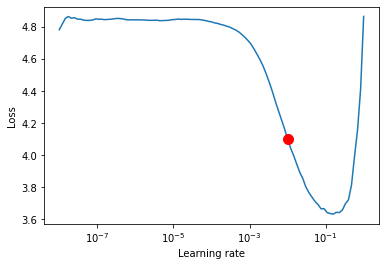

In [93]:
fig = lr_finder.plot(suggest=True)

In [94]:
lr_finder.suggestion()

0.01

In [96]:


name = 'albert-feature-extract'
logger = TensorBoardLogger(
                save_dir='ts-logs',
                name = name
            )
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
if not os.path.exists(f'saved_models/{name}'):
    os.mkdir(f'saved_models/{name}')
checkpoint_callback = ModelCheckpoint(f'saved_models/{name}', save_top_k=2)
early_stopping = EarlyStopping(monitor='val_loss')


trainer = pl.Trainer(max_epochs=10,
                     checkpoint_callback=checkpoint_callback,
                     logger=logger,
                    early_stop_callback=early_stopping,
                    auto_lr_find=False)

GPU available: True, used: False
No environment variable for node rank defined. Set as 0.


In [97]:
trainer.fit(tweet_model)


   | Name                                                                             | Type                       | Params
----------------------------------------------------------------------------------------------------------------------------
0  | model                                                                            | AlbertForQuestionAnswering | 11 M  
1  | model.albert                                                                     | AlbertModel                | 11 M  
2  | model.albert.embeddings                                                          | AlbertEmbeddings           | 3 M   
3  | model.albert.embeddings.word_embeddings                                          | Embedding                  | 3 M   
4  | model.albert.embeddings.position_embeddings                                      | Embedding                  | 65 K  
5  | model.albert.embeddings.token_type_embeddings                                    | Embedding                  | 256   
6  | m

1

In [31]:
lr_finder = trainer.lr_find(tweet_model)


   | Name                                                                             | Type                       | Params
----------------------------------------------------------------------------------------------------------------------------
0  | model                                                                            | AlbertForQuestionAnswering | 11 M  
1  | model.albert                                                                     | AlbertModel                | 11 M  
2  | model.albert.embeddings                                                          | AlbertEmbeddings           | 3 M   
3  | model.albert.embeddings.word_embeddings                                          | Embedding                  | 3 M   
4  | model.albert.embeddings.position_embeddings                                      | Embedding                  | 65 K  
5  | model.albert.embeddings.token_type_embeddings                                    | Embedding                  | 256   
6  | m

In [32]:
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

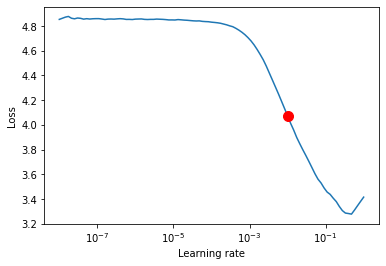

In [33]:
fig = lr_finder.plot(suggest=True)

In [34]:
lr_finder.suggestion()

0.01

In [35]:
hparams.lr = 0.01

In [41]:
tweet_model = TweetModel(hparams)
finetune_model(tweet_model, 5)

name = 'albert'
logger = TensorBoardLogger(
                save_dir='ts-logs',
                name = name
            )
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
if not os.path.exists(f'saved_models/{name}'):
    os.mkdir(f'saved_models/{name}')
checkpoint_callback = ModelCheckpoint(f'saved_models/{name}', save_top_k=2)
early_stopping = EarlyStopping(monitor='val_jaccard')

tweet_model.cuda()
trainer = pl.Trainer(max_epochs=10,
                     checkpoint_callback=checkpoint_callback,
                     logger=logger,
                    early_stop_callback=early_stopping,
                    auto_lr_find=False)
trainer.fit(tweet_model)

GPU available: True, used: False
No environment variable for node rank defined. Set as 0.

   | Name                                                                             | Type                       | Params
----------------------------------------------------------------------------------------------------------------------------
0  | model                                                                            | AlbertForQuestionAnswering | 11 M  
1  | model.albert                                                                     | AlbertModel                | 11 M  
2  | model.albert.embeddings                                                          | AlbertEmbeddings           | 3 M   
3  | model.albert.embeddings.word_embeddings                                          | Embedding                  | 3 M   
4  | model.albert.embeddings.position_embeddings                                      | Embedding                  | 65 K  
5  | model.albert.embeddings.token_type_

1

## change to val_loss for early stopping

In [49]:
import torch

In [54]:
ckpt_ = torch.load('saved_models/albert/epoch=2.ckpt')
tweet_model.load_state_dict(ckpt_['state_dict'])

In [56]:


name = 'albert'
logger = TensorBoardLogger(
                save_dir='ts-logs',
                name = name
            )
checkpoint_callback = ModelCheckpoint(f'saved_models/{name}', save_top_k=2)
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5)

tweet_model.cuda()

TweetModel(
  (model): AlbertForQuestionAnswering(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
            

In [57]:
trainer = pl.Trainer(max_epochs=10,
                     checkpoint_callback=checkpoint_callback,
                     logger=logger,
                    early_stop_callback=early_stopping,
                    auto_lr_find=False)
trainer.fit(tweet_model)

GPU available: True, used: False
No environment variable for node rank defined. Set as 0.

   | Name                                                                             | Type                       | Params
----------------------------------------------------------------------------------------------------------------------------
0  | model                                                                            | AlbertForQuestionAnswering | 11 M  
1  | model.albert                                                                     | AlbertModel                | 11 M  
2  | model.albert.embeddings                                                          | AlbertEmbeddings           | 3 M   
3  | model.albert.embeddings.word_embeddings                                          | Embedding                  | 3 M   
4  | model.albert.embeddings.position_embeddings                                      | Embedding                  | 65 K  
5  | model.albert.embeddings.token_type_

Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [65]:
get_trainable_params(tweet_model)

592898

In [66]:
finetune_model(tweet_model,8)

In [67]:
print_trainable_params(tweet_model)

model.albert.encoder.albert_layer_groups.0.albert_layers.0.ffn.weight
model.albert.encoder.albert_layer_groups.0.albert_layers.0.ffn.bias
model.albert.encoder.albert_layer_groups.0.albert_layers.0.ffn_output.weight
model.albert.encoder.albert_layer_groups.0.albert_layers.0.ffn_output.bias
model.albert.pooler.weight
model.albert.pooler.bias
model.qa_outputs.weight
model.qa_outputs.bias


In [68]:
trainer.lr_find(tweet_model)


   | Name                                                                             | Type                       | Params
----------------------------------------------------------------------------------------------------------------------------
0  | model                                                                            | AlbertForQuestionAnswering | 11 M  
1  | model.albert                                                                     | AlbertModel                | 11 M  
2  | model.albert.embeddings                                                          | AlbertEmbeddings           | 3 M   
3  | model.albert.embeddings.word_embeddings                                          | Embedding                  | 3 M   
4  | model.albert.embeddings.position_embeddings                                      | Embedding                  | 65 K  
5  | model.albert.embeddings.token_type_embeddings                                    | Embedding                  | 256   
6  | m

LR finder stopped early due to diverging loss.


In [ ]:
trainer = pl.Trainer(max_epochs=10,
                     checkpoint_callback=checkpoint_callback,
                     logger=logger,
                    early_stop_callback=early_stopping,
                    auto_lr_find=False)
trainer.fit(tweet_model)

In [35]:

hparams = dict(tokenizer=tokenizer,
           train_df=train_df, 
           val_df=val_df,
           lr=3e-5, batch_size=64,
           n_workers=4)
hparams = Namespace(**hparams)

In [39]:
tweet_model.load_from_checkpoint('saved_models/albert/epoch=4.ckpt',
                                hparams_file=hparams)

AttributeError: 'Namespace' object has no attribute 'split'

In [ ]:
%%time

for fold, (train_idx, val_idx) in enumerate(skf.split(train, train.sentiment), start=1): 
    print(f'Fold: {fold}')

    model = TweetModel()
    optimizer = optim.AdamW(model.parameters(), lr=3e-5, betas=(0.9, 0.999))
    criterion = loss_fn    
    dataloaders_dict = get_train_val_loaders(train, train_idx, val_idx, batch_size)

    train_model(
        model, 
        dataloaders_dict,
        criterion, 
        optimizer, 
        num_epochs,
        f'roberta_char_level_fold{fold}.pth')

# Inference

In [ ]:
%%time

test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
test['text'] = test['text'].astype(str)
test_loader = get_test_loader(test)
predictions = []
models = []
for fold in range(skf.n_splits):
    model = TweetModel()
    model.cuda()
    model.load_state_dict(torch.load(f'roberta_fold{fold+1}.pth'))
    model.eval()
    models.append(model)

for data in test_loader:
    ids = data['ids'].cuda()
    masks = data['masks'].cuda()
    tweet = data['tweet']
    offsets = data['offsets'].numpy()

    start_logits = []
    end_logits = []
    for model in models:
        with torch.no_grad():
            output = model(ids, masks)
            start_logits.append(torch.softmax(output[0], dim=1).cpu().detach().numpy())
            end_logits.append(torch.softmax(output[1], dim=1).cpu().detach().numpy())

    start_logits = np.mean(start_logits, axis=0)
    end_logits = np.mean(end_logits, axis=0)
    for i in range(len(ids)):    
        start_pred = np.argmax(start_logits[i])
        end_pred = np.argmax(end_logits[i])
        if start_pred > end_pred:
            pred = tweet[i]
        else:
            pred = get_selected_text(tweet[i], start_pred, end_pred, offsets[i])
        predictions.append(pred)

# Submission

In [ ]:
sub_df = pd.read_csv('../input/tweet-sentiment-extraction/sample_submission.csv')
sub_df['selected_text'] = predictions
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()